In [4]:
!pip install matplotlib

  Using cached matplotlib-3.6.3-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached Pillow-9.4.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-win_amd64.whl (55 kB)
  Using cached contourpy-1.0.6-cp39-cp39-win_amd64.whl (161 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)


In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import pandas as pd
import os
import math

In [8]:
#listing all GPU devices
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
#defining paths
training_path = 'Splitted_dataset/train'
validation_path = 'Splitted_dataset/val'
test_path = 'Splitted_dataset/test'

#Hyper-parameters defining
IMAGE_LENGTH = 224
IMAGE_BREADTH = 224
IMAGE_SIZE = [IMAGE_LENGTH, IMAGE_BREADTH]
BATCH_SIZE = 32

classes_train = glob('Splitted_dataset/train/*')

In [20]:
#VGG19 model used for transfer learning, with imagenet images weight
vgg19_imagenet = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg19_imagenet.layers:
    layer.trainable = False

In [21]:
#Adding flattened layer
x = Flatten()(vgg19_imagenet.output)

#Adding dense layers for training
x = Dense(64, activation='sigmoid')(x)
#x = Dropout(0.1)(x)
x = Dense(32, activation='sigmoid')(x)

#classsification layer including previous layers
classify_layers = Dense(len(classes_train), activation='softmax')(x)

In [22]:
model = Model(inputs=vgg19_imagenet.input, outputs=classify_layers)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [25]:
#loading training dataset
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 19290 images belonging to 2 classes.


In [26]:
#Loading test validation dataset
validation_set = test_datagen.flow_from_directory(validation_path,
                                            target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 5512 images belonging to 2 classes.


In [27]:
#Training the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/50
603/603 [==============================] - 278s 458ms/step - loss: 0.4664 - accuracy: 0.7939 - val_loss: 0.4981 - val_accuracy: 0.7476
Epoch 2/50
603/603 [==============================] - 276s 457ms/step - loss: 0.3210 - accuracy: 0.8720 - val_loss: 0.3114 - val_accuracy: 0.8790
Epoch 3/50
603/603 [==============================] - 276s 457ms/step - loss: 0.2903 - accuracy: 0.8841 - val_loss: 0.3606 - val_accuracy: 0.8592
Epoch 4/50
603/603 [==============================] - 276s 457ms/step - loss: 0.2880 - accuracy: 0.8907 - val_loss: 0.3590 - val_accuracy: 0.8716
Epoch 5/50
603/603 [==============================] - 277s 458ms/step - loss: 0.2804 - accuracy: 0.9008 - val_loss: 0.2654 - val_accuracy: 0.9008
Epoch 6/50
603/603 [==============================] - 277s 459ms/step - loss: 0.2696 - accuracy: 0.9032 - val_loss: 0.3833 - val_accuracy: 0.8619
Epoch 7/50
603/603 [==============================] - 277s 459ms/step - loss: 0.2625 - accuracy: 0.9101 - val_loss: 0.4305 -

In [28]:
#savig the model

model.save(os.path.join('saved_models','transfer_vgg19.h5'))

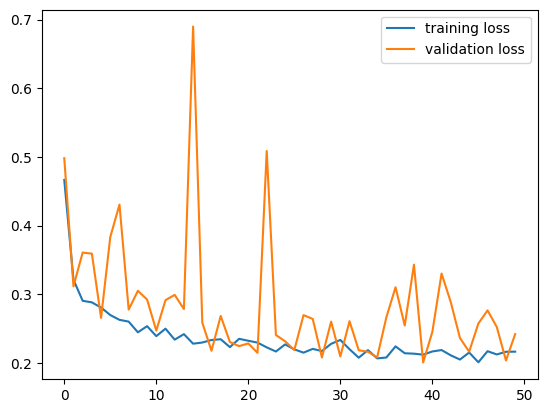

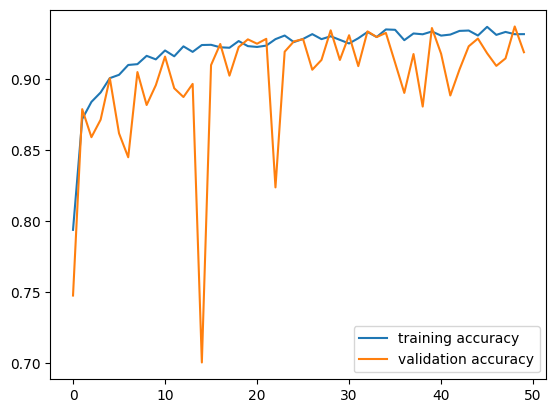

<Figure size 640x480 with 0 Axes>

In [29]:
#Model performance plot

#plotting the losses
plt.plot(r.history['loss'], label='training loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('model_performances_plots/Transfer_VGG19_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='training accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('model_performances_plots/Transfer_VGG19_Accuracy')

<h2>Model Evaluation with Test Dataset<h2>

In [11]:
#loading test dataset
test_dataset = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path,
                                                 target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 2756 images belonging to 2 classes.


In [4]:
#loading the model
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join('saved_models','transfer_vgg19.h5'))

In [7]:
#Importing and initializing metrics
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [8]:
accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()
tp = TruePositives()
tn = TrueNegatives()
fp = FalsePositives()
fn = FalseNegatives()

In [9]:
#Iterating over test dataset and updating metrics, structure[infected,uninfected]
i = 1
for batch in test_dataset:
    print("starting batch",i)
    images, y = batch
    #plt.imshow(images[0])
    yhat = loaded_model.predict(images)
    y=y[: , :1]
    yhat=yhat[: , :1]
    #print(y)
    #print(yhat)
    accuracy.update_state(y, yhat)
    precision.update_state(y, yhat)
    tp.update_state(y, yhat)
    tn.update_state(y, yhat)
    fp.update_state(y, yhat)
    fn.update_state(y, yhat)
    recall.update_state(y, yhat)
    print('completed bacth',i)
    i = i+1
    if i>math.ceil(2756/BATCH_SIZE):
        break

starting batch 1
completed bacth 1
starting batch 2
completed bacth 2
starting batch 3
completed bacth 3
starting batch 4
completed bacth 4
starting batch 5
completed bacth 5
starting batch 6
completed bacth 6
starting batch 7
completed bacth 7
starting batch 8
completed bacth 8
starting batch 9
completed bacth 9
starting batch 10
completed bacth 10
starting batch 11
completed bacth 11
starting batch 12
completed bacth 12
starting batch 13
completed bacth 13
starting batch 14
completed bacth 14
starting batch 15
completed bacth 15
starting batch 16
completed bacth 16
starting batch 17
completed bacth 17
starting batch 18
completed bacth 18
starting batch 19
completed bacth 19
starting batch 20
completed bacth 20
starting batch 21
completed bacth 21
starting batch 22
completed bacth 22
starting batch 23
completed bacth 23
starting batch 24
completed bacth 24
starting batch 25
completed bacth 25
starting batch 26
completed bacth 26
starting batch 27
completed bacth 27
starting batch 28
c

In [10]:
print("accuracy =",accuracy.result().numpy(),", precision =", precision.result().numpy(),", recall =", recall.result().numpy())
print("true positives =",tp.result().numpy(),", true negatives =",tn.result().numpy(),", false positives =",fp.result().numpy(),"false negatives =",fn.result().numpy())

accuracy = 0.92670536 , precision = 0.9741936 , recall = 0.8766328
true positives = 1208.0 , true negatives = 1346.0 , false positives = 32.0 false negatives = 170.0


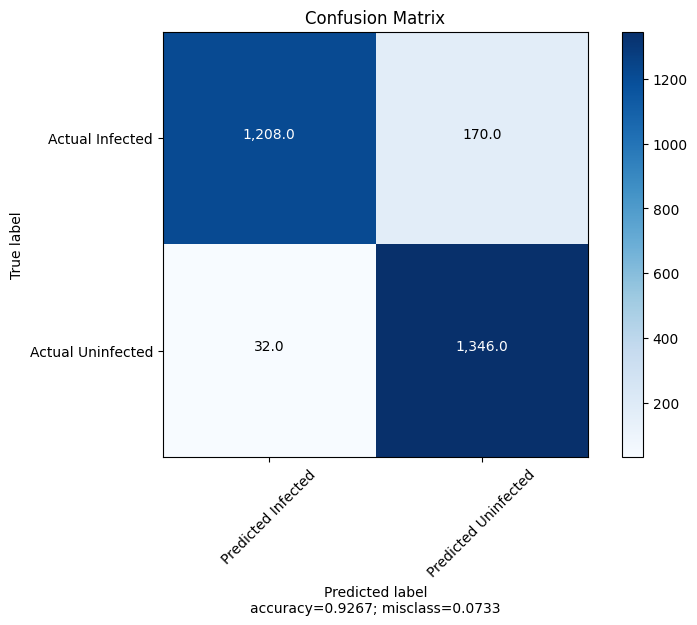

In [19]:
#plotting confusion matrix
#citation: https://www.kaggle.com/code/grfiv4/plot-a-confusion-matrix
import itertools

cm =  np.array([[ tp.result().numpy(),  fn.result().numpy()],
                [  fp.result().numpy(),  tn.result().numpy()]])
normalize = False
cmap = None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.yticks(tick_marks, ["Actual Infected","Actual Uninfected"])
plt.xticks(tick_marks, ["Predicted Infected","Predicted Uninfected"], rotation=45)

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('confusion_matrices/Transfer_VGG19_CM')
plt.show()

<h2>Predicting Single Image<h2>

[[0.9754726  0.02452744]]
Parasitized


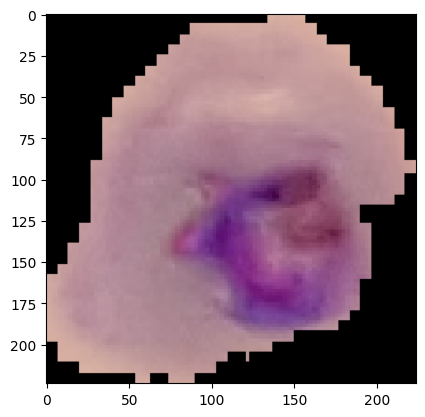

In [5]:
#loading single image from a specific path
from tensorflow.keras.preprocessing import image

img_path='Dataset/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_105102_cell_83.png'
img=image.load_img(img_path,target_size=(224,224))
img=image.img_to_array(img)/255
img=np.expand_dims(img,axis=0)
y=loaded_model.predict(img)
print(y)
plt.imshow(image.load_img(img_path,target_size=(224,224)))

a=np.argmax(y, axis=1)
if(a==1): print("Uninfected")
else: print("Parasitized")

[[1. 0.]]
[[0.975277   0.02472301]]


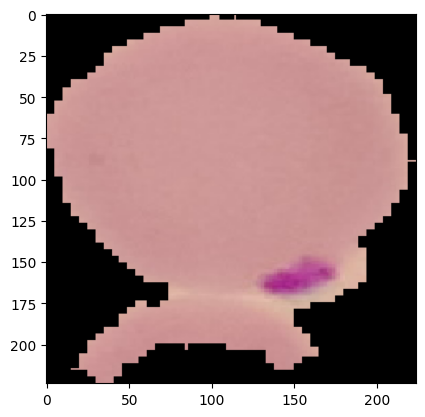

In [12]:
#predicting single image using ImageDatagenerator
i=1
images, y = test_dataset[0]
print(y[i:i+1])
plt.imshow(images[i])
yhat = loaded_model.predict(images[i:i+1])
print(yhat)